In [280]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [281]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from matplotlib import pyplot as plt

In [282]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [283]:
import random

In [284]:
df = pd.read_csv('./airline_passengers.csv',index_col=0)

In [285]:
dates = pd.date_range('1949-01-01','1960-12-01',freq='MS')
df['Date'] = dates
df.set_index('Date', inplace=True)

In [286]:
data=df.iloc[:,0:1].values

In [287]:
def sliding_windows(data,seq_length):
    x=[]
    y=[]
    
    for i in range(len(data)-seq_length-1):
        _x=data[i:i+seq_length]
        _y=data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [288]:
norm=MinMaxScaler()
training_data=norm.fit_transform(data)

In [289]:
seq_length=5
x,y=sliding_windows(training_data,seq_length)

In [290]:
x

array([[[0.01544402],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853]],

       [[0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556]],

       [[0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208]],

       [[0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208]],

       [[0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606]],

       [[0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753]],

       [[0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ]],

       [[0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703]],

       [[0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703],
        [0.02123

In [291]:
train_size=int(len(y)*0.8)
test_size=len(y)-train_size

In [292]:
data_new1=Variable(torch.Tensor(x))
data_new2=Variable(torch.Tensor(y))

train1=Variable(torch.Tensor(x[:train_size]))
train2=Variable(torch.Tensor(y[:train_size]))

test1=Variable(torch.Tensor(x[train_size:]))
test2=Variable(torch.Tensor(y[train_size:]))

In [293]:
train1.shape

torch.Size([110, 5, 1])

In [294]:
class Net(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers ):
        super(Net, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size,1 )


    def forward(self, x):
        
        hidden_prev = torch.zeros(1,x.size(0), hidden_size)
        out, hidden_prev = self.rnn(x, hidden_prev)
        
        hidden_prev = hidden_prev.detach()
        hidden_prev = hidden_prev.view(-1, self.hidden_size)
        # [b, seq, h]
        out=self.linear(hidden_prev)
        return out

In [298]:
seq_length = 5
input_size = 1
hidden_size = 16
num_classes=1
num_layers=1
lr=0.01

In [299]:
model = Net(num_classes, input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

for iter in range(1000):

    output = model(train1)
    loss = criterion(output, train2)
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print("Iteration: {} loss {}".format(iter, loss.item()))

Iteration: 0 loss 0.17733341455459595
Iteration: 100 loss 0.010412320494651794
Iteration: 200 loss 0.003622531658038497
Iteration: 300 loss 0.003032119246199727
Iteration: 400 loss 0.0029822406359016895
Iteration: 500 loss 0.0029467588756233454
Iteration: 600 loss 0.0029108263552188873
Iteration: 700 loss 0.0028753061778843403
Iteration: 800 loss 0.002840995555743575
Iteration: 900 loss 0.002808486809954047


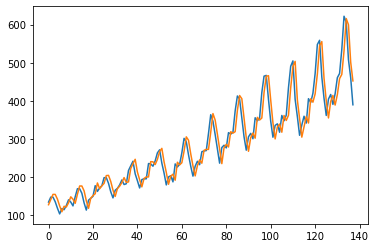

In [300]:
model.eval()
tarin_predict=model(data_new1)

data_predict=tarin_predict.detach().numpy()
data_plot=data_new2.detach().numpy()

data_predict=norm.inverse_transform(data_predict)
data_plot=norm.inverse_transform(data_plot)

plt.plot(data_plot)
plt.plot(data_predict)
plt.show()